# Analysis

In [104]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chisquare

# Load data
df_shuffle = pd.read_csv('../data/shuffle_playthrough.csv', index_col=0)
df_smart_shuffle = pd.read_csv('../data/smart_shuffle_playthrough.csv')
df_shuffle.head()

PLAYLIST_SIZE = 1149
BIN_WIDTH = 30

sns.set_theme()

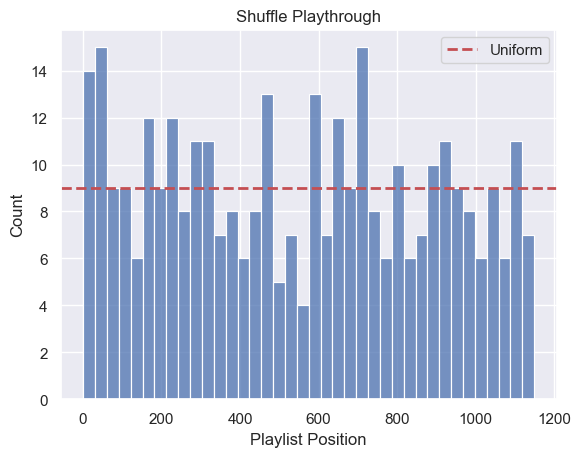

In [107]:
sns.histplot(df_shuffle, x='playlist_pos', binwidth=BIN_WIDTH)
plt.title('Shuffle Playthrough')
plt.xlabel('Playlist Position')
uniform_avg = 1 / (PLAYLIST_SIZE - 1) * BIN_WIDTH * len(df_shuffle)
plt.axhline(y = uniform_avg, color = 'r', lw=2, linestyle = '--', label='Uniform')
plt.legend()

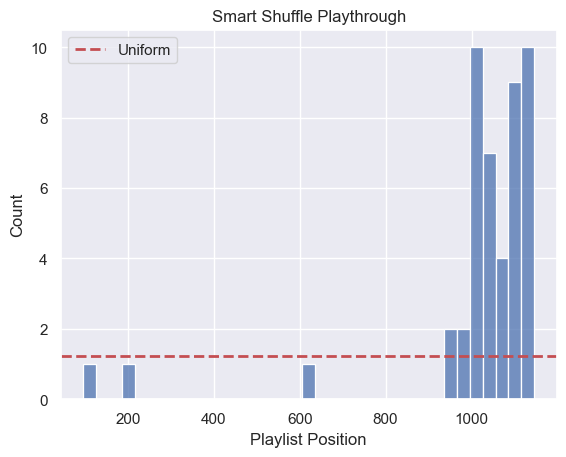

In [109]:
sns.histplot(df_smart_shuffle, x='playlist_pos', binwidth=BIN_WIDTH)
plt.title('Smart Shuffle Playthrough')
plt.xlabel('Playlist Position')
uniform_avg = 1 / (PLAYLIST_SIZE - 1) * BIN_WIDTH * len(df_smart_shuffle)
plt.axhline(y = uniform_avg, color = 'r', lw=2, linestyle = '--', label='Uniform')
plt.legend()

In [ ]:
expected_freq = np.full_like(sample, len(sample) / len(sample))